### Lossely based on Lectures 1 & 2 (https://github.com/karpathy/nn-zero-to-hero)
- ##### I fit randomly generated data
- ##### I use an MLP with one output neuron
- ##### I use Binary Crossentropy as loss function

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

In [3]:
# THA PROSPATHISW NA FITARW RANDOM DATA!
# na xrisimopoisw batches anti gia ola ta deigmata ->  na kanw overfit one batch!
# na eleksw to katallilo lr opws to ekane o karpathy

#### TODO:
- [x] Na prosthesw activation functions-> Einai ola Linear!!
- [x] Na checkarw to arxiko loss-> prepei na einai to loss gia unifor distribution, dld bce(0.5)!
- [x] Na kanw arxikopoiisi pou na mou dinei auto to loss... 
    - (to b2 na to kanw 0 stin arxikopoiisi kai to W2 * 0.1 h W2 * 0.01)
- [ ] Na dokimasw na ilopoiisw batch_norm alla na metatrepsw se uniform distr, oxi se normal -> diki m idea!!! thelw na dw an doulepsei...( diasthitika m fainetai pio swsto!)

In [4]:
# generate random data
num_examples = 1000
num_features = 3

g = torch.Generator().manual_seed(2147483647)
xtrain = torch.randn(num_examples,num_features,generator=g) # random data
y0 = torch.zeros(int(num_examples/2))
y1 = torch.ones(int(num_examples/2))
shuffle = torch.randperm(num_examples,generator=g) 
ytrain = torch.cat((y0,y1),dim=0)[shuffle] # random labels
xtrain.shape, ytrain.shape

(torch.Size([1000, 3]), torch.Size([1000]))

In [5]:
# validation set
val_examples = 100

g = torch.Generator().manual_seed(0) # diaforetiko seed giana parw diaforetika data
xval = torch.randn(val_examples,num_features,generator=g) # random test data

val_y0 = torch.zeros(int(val_examples/2))
val_y1 = torch.ones(int(val_examples/2))
shuffle = torch.randperm(val_examples,generator=g) 
yval = torch.cat((val_y0,val_y1),dim=0)[shuffle] # random labels 
xval.shape, yval.shape

(torch.Size([100, 3]), torch.Size([100]))

In [6]:
# Neural Net parameters
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)
W1 = torch.randn(num_features,n_hidden,generator=g) * (5/3) / (num_features**0.5)  # first layer weights
#b1 = torch.randn(n_hidden,generator=g) * 0.01 # first layer biases # einai perito an exw batch norm
b2 = torch.randn(1,generator=g) * 0.1 # output layer biases
W2 = torch.randn(n_hidden,1,generator=g) * 0.01 # output layer weights
# W1.shape, b1.shape, W2.shape, b2.shape

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))

In [8]:
# h = (x @ W1) + b1
# # broadcasting check
# # 100 5 @ 5 10 -> 100 10
# # 100 10
# #   1 10
# print("h shape: ", h.shape)

# logits = (h @ W2) + b2
# # broadcast check
# # 100 1
# #   1 1
# out = torch.sigmoid(logits)
# print("Logits shape:", logits.shape)
# print("Out shape: ", out.shape)

In [9]:
# def bce(out,target):
#     '''
#         my implementation of binary cross entropy loss
#     '''
#     l = -(target*out.log() + (1-target)*(1-out).log()).mean()
#     return l

# l = F.binary_cross_entropy(out.view(-1), y)
# print("torch bce loss: ", l.item())

# loss = bce(out.view(-1),y)
# print("My bce loss: ", loss.item())

# # assert loss == l # check if my implementation of bce is correct!

In [7]:
parameters = [W1, W2, b2, bngain, bnbias] # add bngain, bnbias and remove b1 cause of batchnorm
model_complexity = sum(p.nelement() for p in parameters) # i measure model complexity just as the number of parameters
print("Model complexity:", model_complexity)
# so that i can run backbrop
for p in parameters:
  p.requires_grad = True

Model complexity: 601


In [11]:
# kanw overfit gia dataset 10x3 me complexity 500

In [12]:
# # lr selection
# lre = torch.linspace(-3, 0, 1000)
# lrs = 10**lre

In [13]:
# Na ilopoisw BatchNorm opws o Karpathy!

In [14]:
epochs = 200000
batch_size = 32
lri = []
lossi = []
ud = [] # update:data ratio

for i in tqdm(range(epochs)):
    
  # minbach construct
  ix = torch.randint(0,xtrain.shape[0],(batch_size,))
  xb, yb = xtrain[ix], ytrain[ix]
  
  # forward pass
  hpreact = (xb @ W1) # + b1 # hidden layer pre-activation
  # BatchNorm layer
  # ---------------------------------------------------------------
  bnmeani = hpreact.mean(dim=0,keepdim=True)
  bnstdi = hpreact.std(dim=0,keepdim=True)
  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  with torch.no_grad():
    bnmean_running = 0.999*bnmean_running + 0.001*bnmeani # mikro momentum gia mikra batch_size 
    bnstd_running = 0.999*bnstd_running + 0.001*bnstdi    # gia na sigklinoun ta running averages!
  # ---------------------------------------------------------------
  
  # Non-Linearity
  h = torch.tanh(hpreact)
  h.retain_grad() # gia na borw na kanw h.grad
  logits = (h @ W2) + b2
  loss = F.binary_cross_entropy_with_logits(logits.view(-1),yb) # mallon pio numericaly stable?

  # backward pass 
  for p in parameters:
    p.grad = None
  loss.backward()

  # update
  # lr = lrs[i]
  lr = 0.09 # decay the lr?
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  with torch.no_grad():
    ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
  # lri.append(lre[i])
  lossi.append(loss.log10().item())
  # print(loss.item())
  # if i>1000:
    # break

100%|██████████████████████████████████| 200000/200000 [06:38<00:00, 502.45it/s]


In [ ]:
plt.figure(figsize=(10,10))
plt.imshow(h.abs()>0.99,cmap='gray', interpolation='nearest')

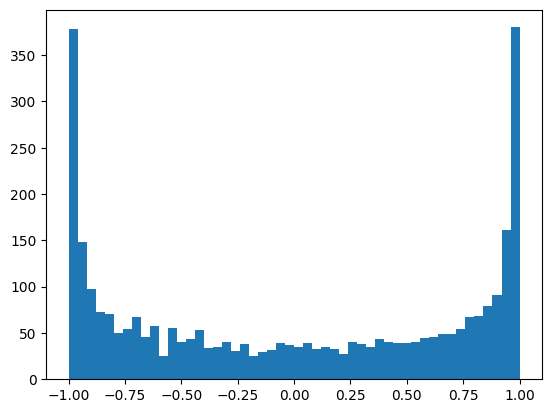

In [123]:
# tanh activation
plt.hist(h.view(-1).tolist(), 50);

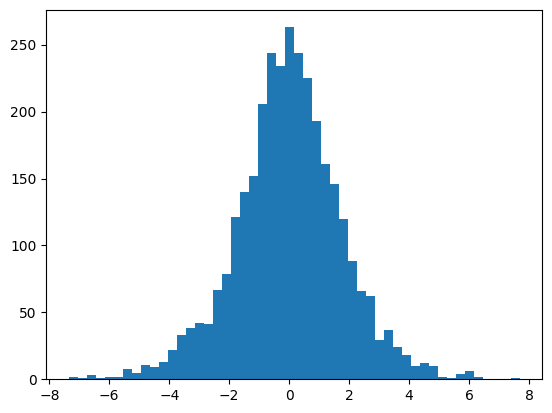

In [124]:
plt.hist(hpreact.view(-1).tolist(), 50);

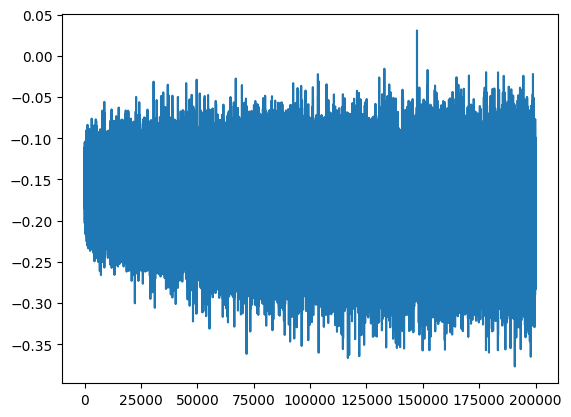

In [15]:
plt.plot(lossi);

In [26]:
# 0.57 0.80
# 0.5237 0.86
# .4588 .9125
# 0.4026 1.098

In [16]:
@torch.no_grad()
def split_loss(split):
  x, y = {
    'train': (xtrain,ytrain),
    'val': (xval,yval)
  }[split]
  hpreact = (x @ W1) # + b1
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias # BatchNorm eval mode
  h = torch.tanh(hpreact)
  logits = (h @ W2) + b2
  # out = torch.sigmoid(logits) # binary classification
  loss = F.binary_cross_entropy_with_logits(logits.view(-1), y)
  print(split, loss.item())

split_loss('train')
split_loss('val')  

train 0.5943197011947632
val 0.7590792775154114


In [ ]:
# me init W1*0.2
train 0.5861955881118774
val 0.8374890089035034

# me swsto init (5/3) / num_features**0.5 2000000 epochs
train 0.3142169415950775
val 1.4306974411010742

Mean: 0.03657420724630356, std: 0.6301196217536926, saturation: 23.96875%


Text(0.5, 1.0, 'Hidden distribution')

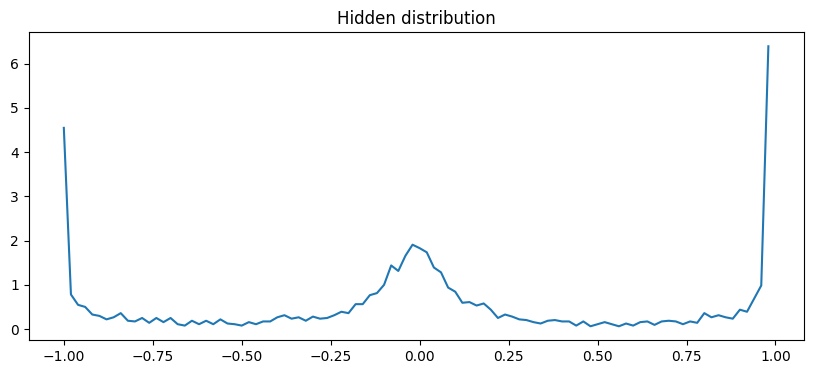

In [17]:
plt.figure(figsize=(10,4))
t = h
print(f"Mean: {t.mean()}, std: {t.std()}, saturation: {(t.abs()>0.97).float().mean()*100}%")
hy, hx = torch.histogram(t,density=True)
plt.plot(hx[:-1].detach(), hy.detach());
plt.title("Hidden distribution")

grad mean: 4.4736220843333285e-06, grad std: 0.008048266172409058


Text(0.5, 1.0, 'Gradient distribution')

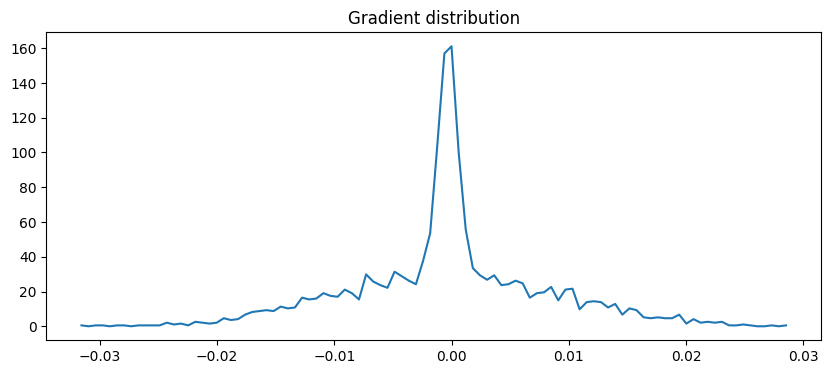

In [18]:
# grad visualization
plt.figure(figsize=(10,4))
t = h.grad
print(f"grad mean: {t.mean()}, grad std: {t.std()}")
hy, hx = torch.histogram(t,density=True)
plt.plot(hx[:-1].detach(), hy.detach());
plt.title("Gradient distribution")

weight: torch.Size([3, 100]) | grad mean -0.0007969450671225786| grad std 0.014385418966412544 | grad:data ratio 0.01187876332551241
weight: torch.Size([100, 1]) | grad mean -0.0006431268411688507| grad std 0.02863740362226963 | grad:data ratio 0.04772281274199486
weight: torch.Size([1, 100]) | grad mean -0.0006376983365043998| grad std 0.00968144740909338 | grad:data ratio 0.006844041403383017
weight: torch.Size([1, 100]) | grad mean -0.0014461405808106065| grad std 0.013384142890572548 | grad:data ratio 0.017373068258166313


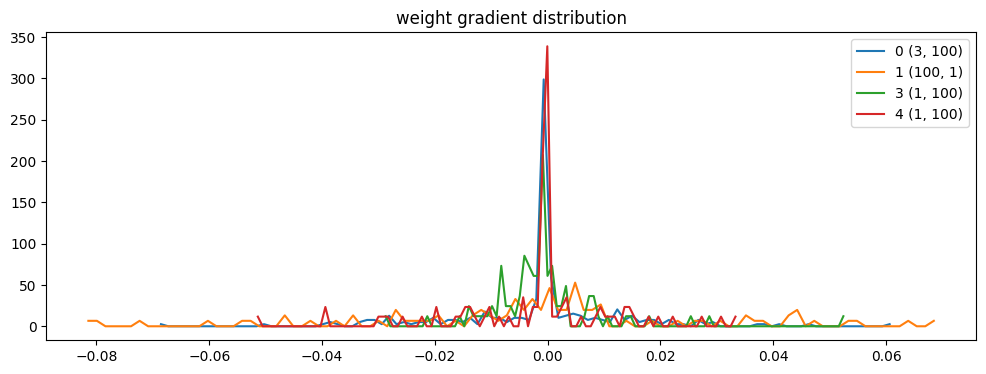

In [19]:
plt.figure(figsize=(12,4))
legends = []
for i,p in enumerate(parameters):
  t = p.grad
  if p.ndim==2: # mono ta weight matrix
    print(f"weight: {p.shape} | grad mean {t.mean()}| grad std {t.std()} | grad:data ratio {t.std()/p.std()}")
    hy, hx = torch.histogram(t,density=True)
    plt.plot(hx[:-1].detach(), hy.detach());
    legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weight gradient distribution');

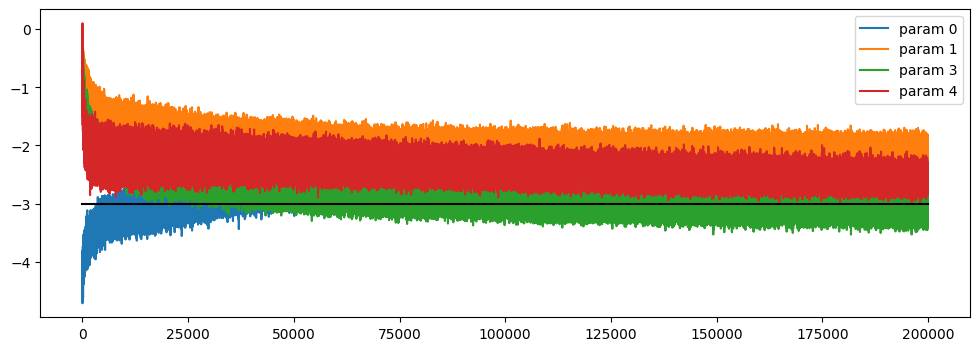

In [20]:
plt.figure(figsize=(12, 4))
legends = []
for i,p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);
# ta Weight W2 tou 2ou layer ksekinoun apo pio psila epeidi ta exw kanei shrink *0.01 gia na exw kalo arxiko loss
# prepei oi metavoles sta vari na einai peripou 1e-3

### Graph result for lr selection

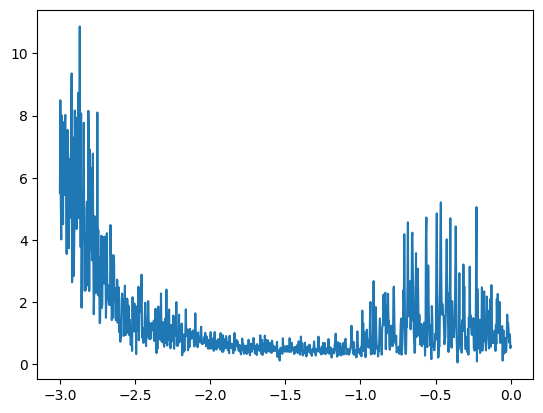

In [79]:
# lr selection
plt.plot(lri,lossi);

# tha epilexw exponent = -2 ara lr = 0.01

In [66]:
# target = torch.tensor([1,0],dtype=torch.float32)
# logits = torch.tensor([5,-10],dtype=torch.float32)
# loss = F.binary_cross_entropy_with_logits(logits,target)
# print(loss.item())
# print(torch.sigmoid(logits))

0.003380383364856243
tensor([9.9331e-01, 4.5398e-05])


In [233]:
# BONUS Karpathy Code: https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part3_bn.ipynb

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import scipy.stats as stats
import numpy as np

def normshow(x0):
  g = torch.Generator().manual_seed(2147483647+1)
  x = torch.randn(5, generator=g) * 5
  x[0] = x0 # override the 0th example with the slider
  mu = x.mean()
  sig = x.std()
  y = (x - mu)/sig

  plt.figure(figsize=(10, 5))
  # plot 0
  plt.plot([-6,6], [0,0], 'k')
  # plot the mean and std
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, mu, sig), 'b')
  xx = np.linspace(-6, 6, 100)
  plt.plot(xx, stats.norm.pdf(xx, 0, 1), 'r')
  # plot little lines connecting input and output
  for i in range(len(x)):
    plt.plot([x[i],y[i]], [1, 0], 'k', alpha=0.2)
  # plot the input and output values
  plt.scatter(x.data, torch.ones_like(x).data, c='b', s=100)
  plt.scatter(y.data, torch.zeros_like(y).data, c='r', s=100)
  plt.xlim(-6, 6)
  # title
  plt.title('input mu %.2f std %.2f' % (mu, sig))

interact(normshow, x0=(-30,30,0.5));


interactive(children=(FloatSlider(value=0.0, description='x0', max=30.0, min=-30.0, step=0.5), Output()), _dom…

In [236]:
# Linear: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

a = torch.randn((1000,1), requires_grad=True, generator=g)          # a.grad = b.T @ c.grad
b = torch.randn((1000,1000), requires_grad=True, generator=g)       # b.grad = c.grad @ a.T
c = b @ a
loss = torch.randn(1000, generator=g) @ c
a.retain_grad()
b.retain_grad()
c.retain_grad()
loss.backward()
print('a std:', a.std().item())
print('b std:', b.std().item())
print('c std:', c.std().item())
print('-----')
print('c grad std:', c.grad.std().item())
print('a grad std:', a.grad.std().item())
print('b grad std:', b.grad.std().item())

a std: 0.9875972270965576
b std: 1.0006722211837769
c std: 31.01241683959961
-----
c grad std: 0.9782556295394897
a grad std: 30.8818302154541
b grad std: 0.9666601419448853


In [22]:
#Linear + BatchNorm: activation statistics of forward and backward pass

g = torch.Generator().manual_seed(2147483647)

n = 1000
# linear layer ---
inp = torch.randn(n, requires_grad=True, generator=g)
w = torch.randn((n, n), requires_grad=True, generator=g) # / n**0.5
x = w @ inp
# bn layer 
# -----------------
xmean = x.mean()
xvar = x.var()
out = (x - xmean) / torch.sqrt(xvar + 1e-5)
# -----------------
loss = out @ torch.randn(n, generator=g)
inp.retain_grad()
x.retain_grad()
w.retain_grad()
out.retain_grad()
loss.backward()

print('inp std: ', inp.std().item())
print('w std: ', w.std().item())
print('x std: ', x.std().item())
print('out std: ', out.std().item())
print('------')
print('out grad std: ', out.grad.std().item())
print('x grad std: ', x.grad.std().item())
print('w grad std: ', w.grad.std().item())
print('inp grad std: ', inp.grad.std().item())

inp std:  0.9875972270965576
w std:  1.0006722211837769
x std:  31.01241683959961
out std:  1.0
------
out grad std:  0.9782556295394897
x grad std:  0.031543977558612823
w grad std:  0.031169468536973
inp grad std:  0.9953053593635559


In [79]:
g = torch.Generator().manual_seed(2147483647)
a = torch.randn((100,1),requires_grad=True, generator=g)
b = torch.randn((100,100),requires_grad=True, generator=g)
c = b @ a
out = (c-c.mean()) / torch.sqrt(c.var() + 1e-6)
a.retain_grad()
b.retain_grad()
c.retain_grad()
out.retain_grad()
loss = out.mean()
loss.backward()
a.mean().item(), a.std().item(), b.mean().item(), b.std().item(), c.mean().item(), c.std().item(), out.mean().item(), out.std().item()

(0.0333213247358799,
 1.0779162645339966,
 -0.006779645569622517,
 0.9998307824134827,
 -0.5120359659194946,
 12.13099193572998,
 2.5033950024067053e-08,
 1.0)

### I also tried some experiments with the following 2 datasets instead of random data.

In [ ]:
# # Attribute Information:
# #    1. Age of patient at time of operation (numerical)
# #    2. Patient's year of operation (year - 1900, numerical) dld an einai 64 ekane tin egxeirisi to 1964!
# #    3. Number of positive axillary nodes detected (numerical)
# #    4. Survival status (class attribute)
# #          1 = the patient survived 5 years or longer
# #          2 = the patient died within 5 year

# # 81 class 2
# # 225 class 1

# # haberman survival dataset
# # https://jamesmccaffrey.wordpress.com/2018/03/14/datasets-for-binary-classification/

# from sklearn import preprocessing

# data = []
# labels = []
# with open('haberman.data','r') as f:
#     for line in f.readlines():
#         data.append(line.split(','))
# data
# for l in data:
#     for i in range(len(l)):
#         l[i] = float(l[i])
#     labels.append(l[len(l)-1])
#     del l[len(l)-1]

# labels = [0 if x==1.0 else 1 for x in labels]
# labels
# # data, labels

# x = np.array(data,dtype=np.float32)
# scaler = preprocessing.StandardScaler().fit(x)
# x = scaler.transform(x)

# x = torch.from_numpy(x)
# y = torch.tensor(labels).float()
# x, y

In [ ]:
# # backnote authentication dataset 
# from sklearn import preprocessing

# data = []
# labels = []
# with open('data_banknote_authentication.txt','r') as f:
#     for line in f.readlines():
#         data.append(line.split(','))
# data
# for l in data:
#     for i in range(len(l)):
#         l[i] = float(l[i])
#     labels.append(l[len(l)-1])
#     del l[len(l)-1]

# x = np.array(data,dtype=np.float32)
# scaler = preprocessing.StandardScaler().fit(x)
# x = scaler.transform(x)

# x = torch.from_numpy(x)
# y = torch.tensor(labels).float()
# g = torch.Generator().manual_seed(2147483647)
# shuffle = torch.randperm(x.shape[0],generator=g)
# x, y = x[shuffle], y[shuffle]
# x.shape, y.shape